# Biweekly Report 5

# Jake Watts

# Oxford-IIIT Pets Image Segmentation

Here I use a new dataset, Oxford-IIT, which contains images of pets and masks showing the pixels containing the pets and the pixels outlining the pets. The data contains images of 37 different pet breeds and contains 3646 training images and 3632 testing images.
 
I use this dataset to create a U-Net with a trained MobileNetV2 as the encoder and an upsample block as the decoder based on the following paper (https://arxiv.org/pdf/1611.07004.pdf). The image segmentation network was made with the help of the following tutorial (https://www.tensorflow.org/tutorials/images/segmentation).


In [ ]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-pt90x_ke
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-pt90x_ke
  Created wheel for tensorflow-examples: filename=tensorflow_examples-336b6c030a3a9c7ac5c17e1800ec91f3e96d9c01_-py3-none-any.whl size=271484 sha256=45d2a9f55f7c9a3528ecba22d05ed69cec317dbfb397aafe4014b64c54a5945a
  Stored in directory: /tmp/pip-ephem-wheel-cache-h002uixr/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

Loading data.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ1FNAU/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ1FNAU/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Functions to resize and then normalize the data.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


Defining model training parameters.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Mapping the resizing and normalizing transformations to the training and testing data.

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Function for augmenting the data with random horizontal flips applied to both the training images and the image masks.

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Defining pipline for training batches.

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Creating function to display data.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In the images below we can see the training data next to the true mask of the data. There are three pixel categories to be defined. The atrea shown in green is surrounding the pet. The area shown in yellow is bordering the pet and the area shown in purple represents the pet.

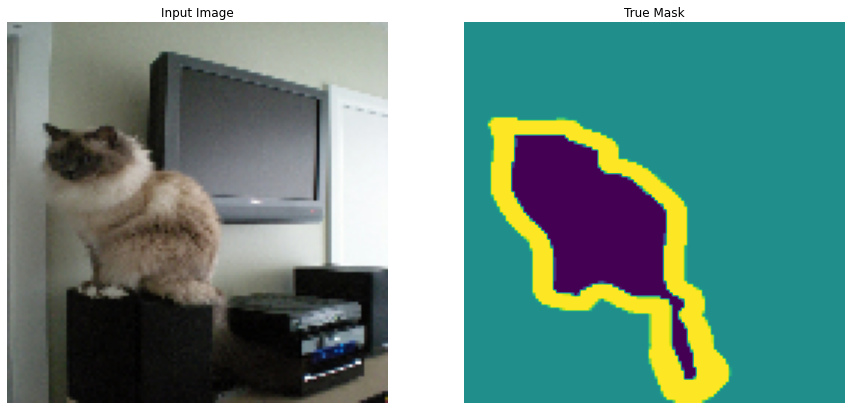

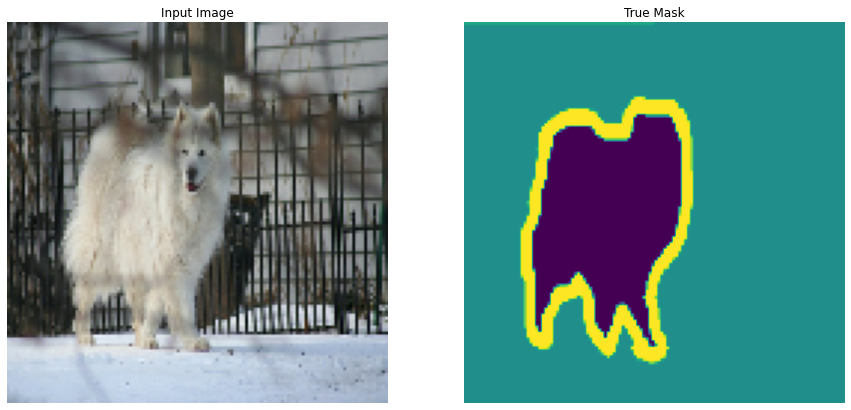

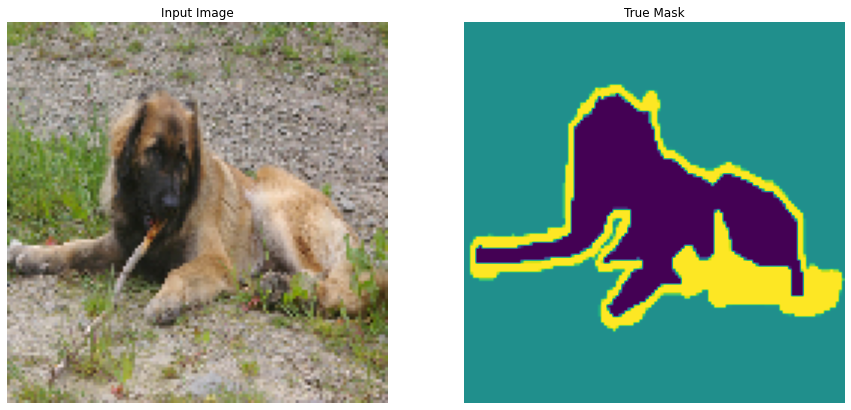

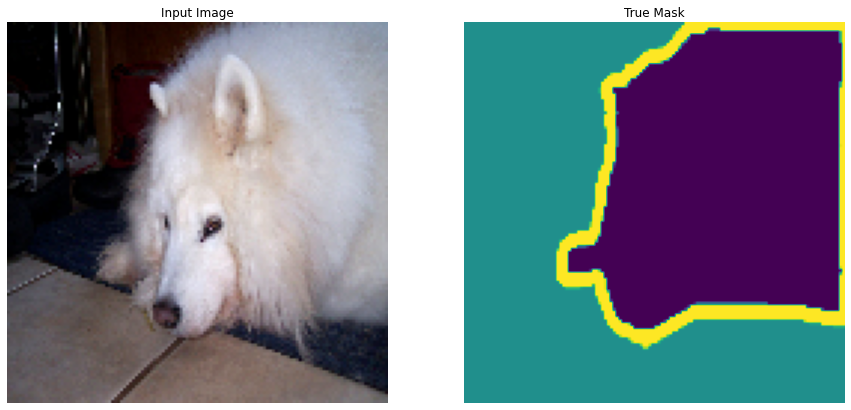

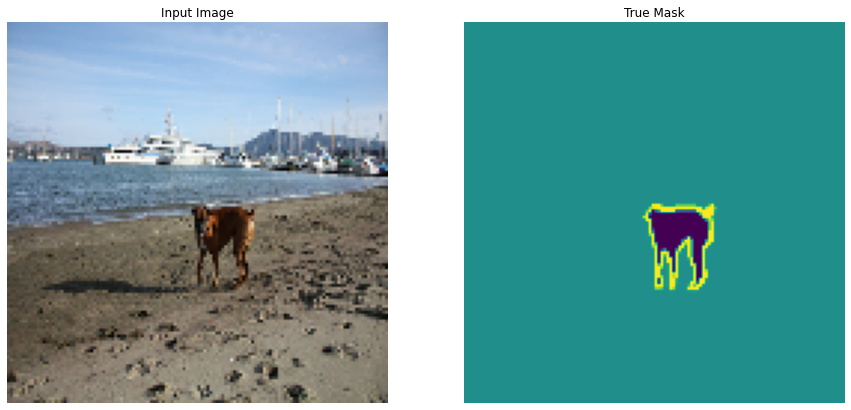

In [ ]:
for images, masks in train_batches.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

Loading in the already trained MobileNetV2 and defining which layers will be used for encoding.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


Defining up_stack to upsample the layers.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Putting the model together with added skip connections.

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Compiling model.

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The plot below shows the structure of the U-Net model. The architecture of this is different than any other model I have previously used in that the input dimensions are the same as the output dimensions since the task being performed is to classify each piexel. We can also see that there are skip connections between every other layer in the model.

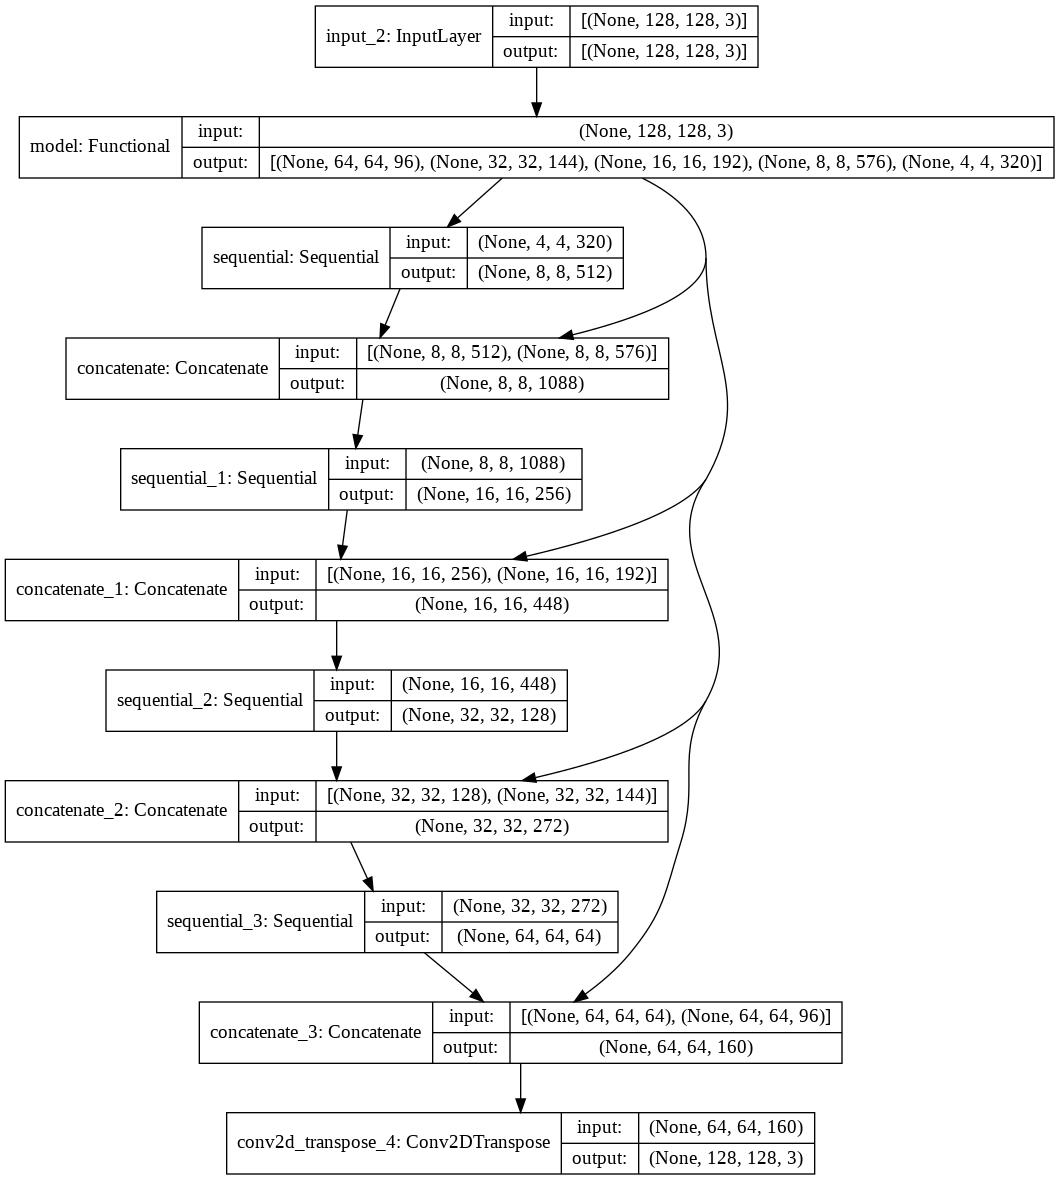

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Functions to create masks to show the model predictions compared with the true mask.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

We can show the predictions without any training and as expceted the predicted mask does not resemble the output mask.

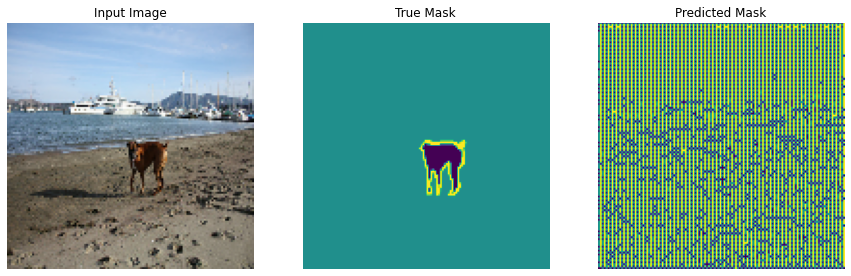

In [ ]:
show_predictions()

Defining callbacks.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Training the model.

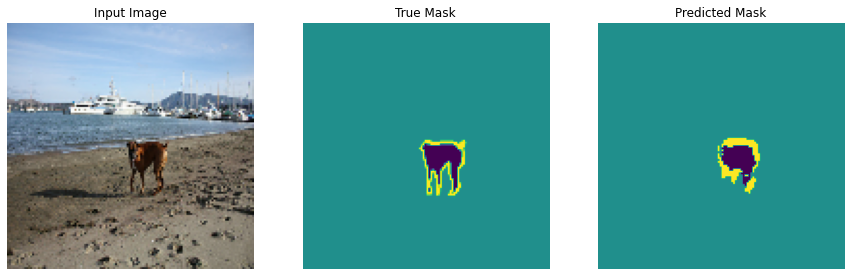


Sample Prediction after epoch 20



In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

After training the model for 20 epochs we can see that the validation loss generally follows the trend of the validation loss, however the validation loss does not decrease as rapidly in the later epochs.

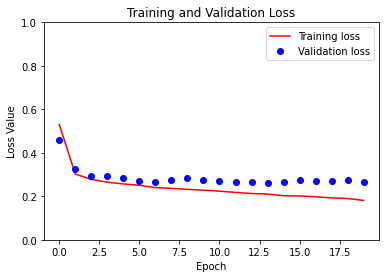

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


Now we can visualize some of the model predictions after training and compare them with the true masks. The predicted images appear to be overall fairly accurate in portraying the shape of the pet. It does seem to have some trouble with getting smooth edges around the pet but whether or not the edges need to be refined likely depends on what application this model is being used for. There are also some small holes predicted in the animals which are not there.
 
It is also worth noting that in some cases the predicted mask appears to fit the image better than the true mask. For example the shape of the ears on the predicted masks of the first two images seem to more closely resemble the shape of the ears than the true mask does.


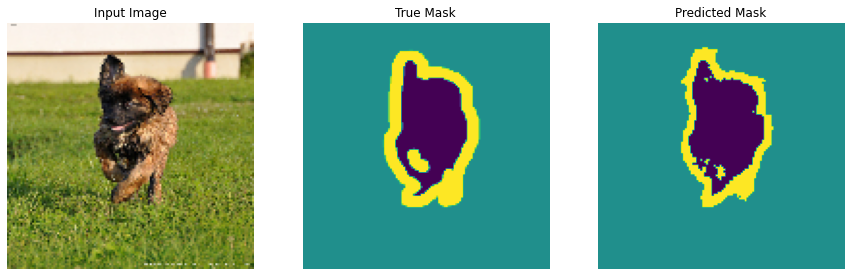

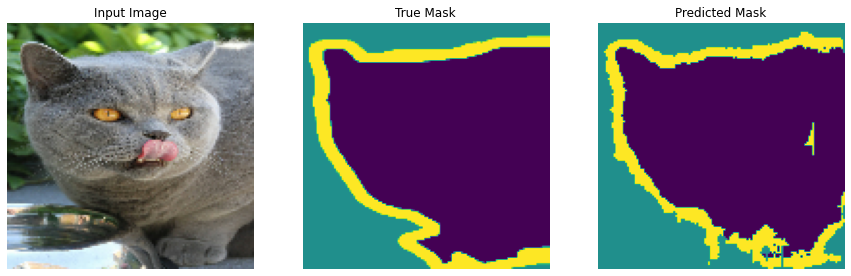

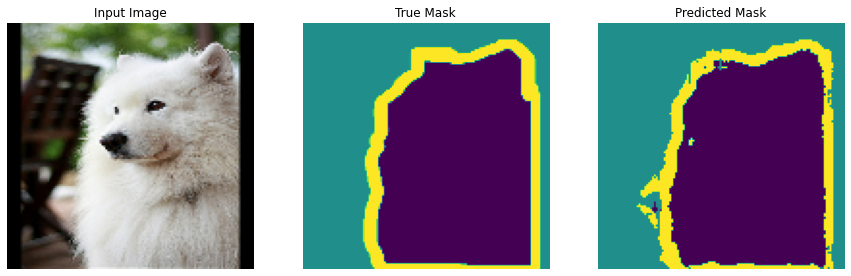

In [ ]:
show_predictions(test_batches, 3)

# Summary
 
In summary the U-Net using pre-trained MobileNetV2 appears to do a good job overall at predicting the masks of the pet data. In some cases it could use a little improvement such as with small details around the edges could be more precise and minimizing holes that aren't there. However in some areas it appears to get the edges even more accurately than the true mask so overall the model appears to work well.
